## Gradient Boosting Classifier

Machine learning boosting is a method for creating an ensemble. It starts by fitting an initial model (e.g. a tree or linear regression) to the data. Then a second model is built that focuses on accurately predicting the cases where the first model performs poorly. The combination of these two models is expected to be better than either model alone. Then you repeat this process of boosting many times.  Each successive model attempts to correct for the shortcomings of the combined boosted ensemble of all previous models.

### Gradient Boosting Explained

Gradient boosting is a type of machine learning boosting. It relies on the intuition that the best possible next model, when combined with previous models, minimizes the overall prediction error. The key idea is to set the target outcomes for this next model in order to minimize the error. How are the targets calculated? The target outcome for each case in the data depends on how much changing that case’s prediction impacts the overall prediction error:

- If a small change in the prediction for a case causes a large drop in error, then next target outcome of the case is a high value. Predictions from the new model that are close to its targets will reduce the error.
- If a small change in the prediction for a case causes no change in error, then next target outcome of the case is zero. Changing this prediction does not decrease the error.

The name gradient boosting arises because target outcomes for each case are set based on the gradient of the error with respect to the prediction. Each new model takes a step in the direction that minimizes prediction error, in the space of possible predictions for each training case.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn preprocessing for dealing with categorical variables

from sklearn.preprocessing import LabelEncoder
import sklearn.ensemble
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix
from inspect import signature

from sklearn.preprocessing import label_binarize

from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from scipy import interp
from itertools import cycle
from sklearn.metrics import classification_report
import pickle

### Load the Training Data

In [2]:
inputData = pd.read_csv('trainData_set1.csv')

#### Replace Upcylce and Downcycle to Up and Down in the Indicative Tick Direction Column

In [3]:
inputData.TICKDIR.describe()

count     52396
unique        5
top        FLAT
freq      47029
Name: TICKDIR, dtype: object

In [4]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN          1685
DOWNCYCLE     1163
FLAT         47029
UP            1665
UPCYCLE        854
Name: TIME, dtype: int64

In [5]:
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('UPCYCLE', 'UP')
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('DOWNCYCLE', 'DOWN')

In [6]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN     2848
FLAT    47029
UP       2519
Name: TIME, dtype: int64

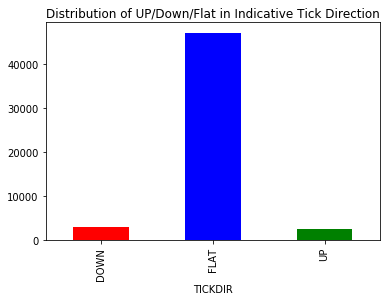

In [7]:
subset.plot(kind='bar', title='Distribution of UP/Down/Flat in Indicative Tick Direction',
           color=['red','blue','green']);

#### Extract a single feature - bid ask imbalance

In [8]:
# extracting a single feature
X = inputData.BIDASKIMBALANCE

#### Reshaping X as it has only one feature

In [9]:
X = np.array(X).reshape(-1,1)

In [10]:
X.shape

(52396, 1)

### Multi Classification 

#### Converting the Indicative Tick Direction to numerical format

In [11]:
y = inputData.TICKDIR.replace('UP', 1)
y = y.replace('FLAT', 0)
y = y.replace('DOWN', -1)

In [12]:
y.shape

(52396,)

#### Train test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

#### Learn to predict each class against the other

In [14]:
classifier = sklearn.ensemble.GradientBoostingClassifier(n_estimators=500)

In [15]:
y_score = classifier.fit(X_train, y_train)

#### Save the model

In [39]:
# save the model to disk
filename = 'gradient_boosting.sav'
pickle.dump(classifier, open(filename, 'wb'))

#### Load the model

In [40]:
loaded_classifier = pickle.load(open(filename, 'rb'))

#### Classifying by Random Forest and Gradient Boosting

In [43]:
y_score = classifier.predict_proba(X_test)

In [17]:
y_pred = classifier.predict(X_test)

In [18]:
#y_score = y_score[:,1]

In [42]:
y_score[0]

array([0.02191432, 0.97635896, 0.00172672])

#### Plot Distribution of the Prediction

In [20]:
prediction = pd.DataFrame({'prediction': y_pred})
prediction1 = prediction.reset_index()
summary = prediction1.groupby(by='prediction').count()
summary

index
prediction       
-1             99
 0           5040
 1            101

In [21]:
actual = pd.DataFrame({'actual': y_test})
actualreset = actual.reset_index()
summary1 = actualreset.groupby(by='actual').count()
summary1

index
actual       
-1        281
 0       4706
 1        253

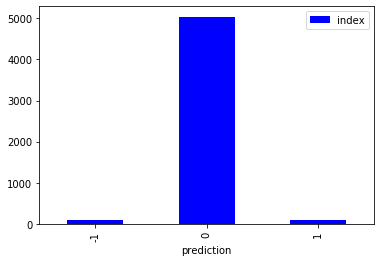

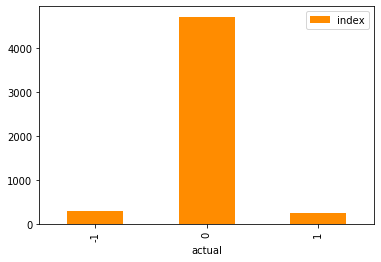

In [22]:
prediction = pd.DataFrame({'prediction': y_pred})
prediction1 = prediction.reset_index()
summary = prediction1.groupby(by='prediction').count()
summary.plot(kind='bar', color='blue');

actual = pd.DataFrame({'actual': y_test})
actualreset = actual.reset_index()
summary1 = actualreset.groupby(by='actual').count()
summary1.plot(kind='bar', color='darkorange');

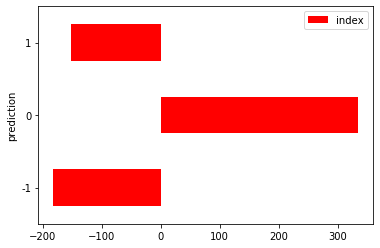

In [23]:
summary2 = summary - summary1
#ax = summary2.plot(kind='barh', color='red', figsize=(5,5))
#for p in ax.patches:
#    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
summary2.plot(kind='barh', color='red');

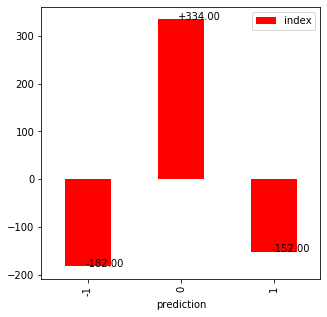

In [24]:
ax = summary2.plot(kind='bar', color='red', figsize=(5,5))
x_offset = -0.03
y_offset = 0.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:+.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

In [25]:
y_score[0:15]

array([[0.02191432, 0.97635896, 0.00172672],
       [0.00276835, 0.92738056, 0.06985109],
       [0.03008719, 0.96803797, 0.00187484],
       [0.00187786, 0.907737  , 0.09038515],
       [0.01233917, 0.94378518, 0.04387565],
       [0.00458336, 0.60837105, 0.38704558],
       [0.1477617 , 0.8502119 , 0.0020264 ],
       [0.02328662, 0.97492375, 0.00178963],
       [0.02701664, 0.94019222, 0.03279114],
       [0.00187337, 0.92604821, 0.07207842],
       [0.00586722, 0.98748153, 0.00665126],
       [0.00304141, 0.86631759, 0.13064099],
       [0.00739344, 0.98383467, 0.00877189],
       [0.00230357, 0.98723007, 0.01046636],
       [0.00347644, 0.54881038, 0.44771318]])

In [26]:
y_score[:15,2]

array([0.00172672, 0.06985109, 0.00187484, 0.09038515, 0.04387565,
       0.38704558, 0.0020264 , 0.00178963, 0.03279114, 0.07207842,
       0.00665126, 0.13064099, 0.00877189, 0.01046636, 0.44771318])

In [27]:
localPredict = []

for i,j,k in zip(y_score[:,0], y_score[:,1], y_score[:,2]):
    
    if i > 0.23:
        predict = -1
        localPredict.append(predict)
    
    elif k > 0.25:
        predict = 1
        localPredict.append(predict)
        
    else:
        predict = 0
        localPredict.append(predict)

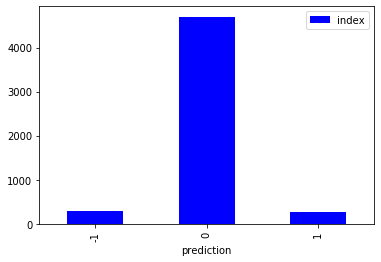

In [28]:
localPrediction = pd.DataFrame({'prediction': localPredict})
localPrediction1 = localPrediction.reset_index()
summary3 = localPrediction1.groupby(by='prediction').count()
summary3.plot(kind='bar', color='blue');

In [29]:
summary4 = summary3 - summary1
ax = summary4.plot(kind='bar', color='red', figsize=(5,5))
x_offset = -0.03
y_offset = 0.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:+.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

#### Accuracy Score

In [30]:
accuracy_score(y_test, y_pred)

0.908969465648855

In [31]:
accuracy_score(y_test, localPredict)

0.8889312977099236

#### Confusion Matrix

In [32]:
confusion_matrix(y_test, y_pred)

array([[  60,  220,    1],
       [  37, 4636,   33],
       [   2,  184,   67]])

In [33]:
confusion_matrix(y_test, localPredict)

array([[ 116,  164,    1],
       [ 164, 4413,  129],
       [   2,  122,  129]])

#### Classification Report

#### Precision:
- The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
- The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

- The best value is 1 and the worst value is 0.

#### Recall:
- The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
- The recall is intuitively the ability of the classifier to find all the positive samples.

- The best value is 1 and the worst value is 0.

#### F-1 Score:
- The F1 score can be interpreted as a weighted average of the precision and recall.
- An F1 score reaches its best value at 1 and worst score at 0.
- The relative contribution of precision and recall to the F1 score are equal.
- F1 = 2 x (precision x recall) / (precision + recall)

In [34]:
print(classification_report(y_test, y_pred, labels=[-1,0,1]))

              precision    recall  f1-score   support

          -1       0.61      0.21      0.32       281
           0       0.92      0.99      0.95      4706
           1       0.66      0.26      0.38       253

    accuracy                           0.91      5240
   macro avg       0.73      0.49      0.55      5240
weighted avg       0.89      0.91      0.89      5240



In [35]:
print(classification_report(y_test, localPredict, labels=[-1,0,1]))

              precision    recall  f1-score   support

          -1       0.41      0.41      0.41       281
           0       0.94      0.94      0.94      4706
           1       0.50      0.51      0.50       253

    accuracy                           0.89      5240
   macro avg       0.62      0.62      0.62      5240
weighted avg       0.89      0.89      0.89      5240



#### Combine classifier with forecasted data

In [44]:
loaded_classifier = pickle.load(open(filename, 'rb'))

In [47]:
df0 = pd.read_csv('tempfile_3.csv', index_col=0)

In [55]:
df1 = df0.dropna()

In [97]:
X = np.array(df1.SS1.values)

In [98]:
X.shape

(121,)

In [99]:
X1 = X.reshape(X.shape[0],1)

In [100]:
y_score = loaded_classifier.predict_proba(X1)

In [101]:
localPredict = []

for i,j,k in zip(y_score[:,0], y_score[:,1], y_score[:,2]):
    
    if i > 0.23:
        predict = -1
        localPredict.append(predict)
    
    elif k > 0.25:
        predict = 1
        localPredict.append(predict)
        
    else:
        predict = 0
        localPredict.append(predict)

In [102]:
localPrediction = pd.DataFrame({'prediction': localPredict})
localPrediction1 = localPrediction.reset_index()
summary3 = localPrediction1.groupby(by='prediction').count()
summary3.plot(kind='bar', color='blue');

In [123]:
features = ['LS1'
            ,'LS2','LS3','LS4','LS5','LS6','LS7','LS8','LS9','LS10','LS11','LS12','LS13','LS14','LS15','LS16',
 'LS17','LS18','LS19','LS20','MS1','MS2','MS3','MS4','MS5','MS6','MS7','MS8','MS9','MS10','SS1','SS2','SS3','SS4',
 'SS5', 'BIDASKIMBALANCE']

In [124]:
outDF = df1
for f in features:
    
    print(np.array(df1[f].values))
    
    X = np.array(df1[f].values)
    X1 = X.reshape(X.shape[0],1)
    y_score = loaded_classifier.predict_proba(X1)
    localPredict = []

    for i,j,k in zip(y_score[:,0], y_score[:,1], y_score[:,2]):

        if i > 0.23:
            predict = -1
            localPredict.append(predict)

        elif k > 0.25:
            predict = 1
            localPredict.append(predict)

        else:
            predict = 0
            localPredict.append(predict)
    
    col_name = f + '_c'
    localPrediction = pd.DataFrame({col_name: localPredict})
    outDF = outDF.join(localPrediction)

[0.14076644 0.14608642 0.14759043 0.14652249 0.14959145 0.15272212
 0.1571275  0.15744725 0.15766475 0.15794379 0.15832081 0.15883447
 0.15926623 0.15962298 0.16003719 0.16001451 0.15965703 0.1604079
 0.1611722  0.1616348  0.16219485 0.16238782 0.16263707 0.16281042
 0.16309117 0.16340953 0.16382998 0.16442285 0.16518286 0.166129
 0.16735487 0.16906288 0.1697702  0.17069255 0.17076938 0.17089866
 0.17100592 0.17090304 0.17065246 0.17194414 0.17374669 0.17579259
 0.17861132 0.17967157 0.18111174 0.18286315 0.18527631 0.18811005
 0.19223234 0.19156794 0.18996365 0.18761915 0.18522373 0.1883059
 0.19285823 0.19293553 0.19288336 0.19165364 0.18922292 0.19221318
 0.19651137 0.19636244 0.19608822 0.1956373  0.19503805 0.19411054
 0.19255249 0.19116321 0.18884617 0.19198273 0.19659947 0.19694555
 0.19735706 0.19769834 0.19816343 0.19779564 0.19699857 0.19577515
 0.19384594 0.19103104 0.19336428 0.19674744 0.19539529 0.19504414
 0.19457164 0.19360703 0.1920875  0.18978919 0.19281289 0.19722264

In [125]:
outDF.head()

TRADEDATE          TIME   BID  BIDSIZE  ASK  ASKSIZE  BIDASKIMBALANCE  \
0   20170703  10:59:32.944  9.55  1220700  9.6    11700         0.981013   
1   20170703  10:59:35.938  9.55  1220700  9.6    12000         0.980531   
2   20170703  10:59:36.850  9.55  1220700  9.6   111900         0.832058   
3   20170703  10:59:37.936  9.55  1220700  9.6   113600         0.829723   
4   20170703  10:59:37.936  9.55  1220700  9.6   113500         0.829861   

   OPEN TICKDIR  BIDVOLUME  ...  MS7_c  MS8_c  MS9_c  MS10_c  SS1_c  SS2_c  \
0  9.55    FLAT          0  ...      0      0      0       0      0      0   
1  9.55    FLAT          0  ...      1      0      0       0      0      0   
2  9.55    FLAT          0  ...      0      0      0       0      0      0   
3  9.55    FLAT          0  ...      0      0      0       0      0      0   
4  9.55    FLAT          0  ...      0      0      0       0      0      0   

   SS3_c  SS4_c  SS5_c  BIDASKIMBALANCE_c  
0      0      0      0                  1  
1      1      0      0                  1  
2      1      0      0                  1  
3      0      0      0                  1  
4      0      0      0                  1  

[5 rows x 114 columns]

In [126]:
list(outDF)

['TRADEDATE',
 'TIME',
 'BID',
 'BIDSIZE',
 'ASK',
 'ASKSIZE',
 'BIDASKIMBALANCE',
 'OPEN',
 'TICKDIR',
 'BIDVOLUME',
 'ASKVOLUME',
 'TOTALBIDVOLUME',
 'TOTALASKVOLUME',
 'TOTALVOLUME',
 'BID1',
 'ASK1',
 'BID2',
 'ASK2',
 'BID3',
 'ASK3',
 'BIDVOLUME1',
 'ASKVOLUME1',
 'BIDVOLUME2',
 'ASKVOLUME2',
 'BIDVOLUME3',
 'ASKVOLUME3',
 'BIDTRADE',
 'ASKTRADE',
 'BIDTRADE1',
 'ASKTRADE1',
 'BIDTRADE2',
 'ASKTRADE2',
 'BIDTRADE3',
 'ASKTRADE3',
 'LASTTICKDIR',
 'LASTTICKDIR1',
 'LASTTICKDIR2',
 'LASTTICKDIR3',
 'LASTTICKDURATION',
 'LASTTICKDURATION1',
 'LASTTICKDURATION2',
 'LASTTICKDURATION3',
 'MARKETTIME',
 'LS1',
 'LS2',
 'LS3',
 'LS4',
 'LS5',
 'LS6',
 'LS7',
 'LS8',
 'LS9',
 'LS10',
 'LS11',
 'LS12',
 'LS13',
 'LS14',
 'LS15',
 'LS16',
 'LS17',
 'LS18',
 'LS19',
 'LS20',
 'MS1',
 'MS2',
 'MS3',
 'MS4',
 'MS5',
 'MS6',
 'MS7',
 'MS8',
 'MS9',
 'MS10',
 'SS1',
 'SS2',
 'SS3',
 'SS4',
 'SS5',
 'LS1_c',
 'LS2_c',
 'LS3_c',
 'LS4_c',
 'LS5_c',
 'LS6_c',
 'LS7_c',
 'LS8_c',
 'LS9_c',
 'LS10_c'

In [127]:
features1 = ['LS1_c','LS2_c','LS3_c','LS4_c','LS5_c','LS6_c','LS7_c','LS8_c','LS9_c','LS10_c','LS11_c','LS12_c',
 'LS13_c','LS14_c','LS15_c','LS16_c','LS17_c','LS18_c','LS19_c','LS20_c','MS1_c','MS2_c','MS3_c','MS4_c',
 'MS5_c','MS6_c','MS7_c','MS8_c','MS9_c','MS10_c','SS1_c','SS2_c','SS3_c','SS4_c','SS5_c','BIDASKIMBALANCE_c']

In [140]:
result = outDF[features1]

In [138]:
outDF['cum_pred'] = result.sum(axis = 1, skipna = True)

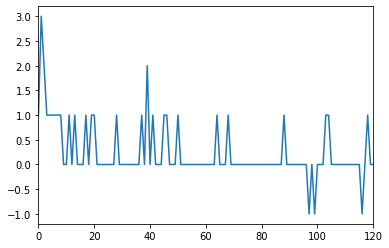

In [153]:
outDF['cum_pred'].plot()

In [164]:
# define how to select final class for flat
outcome = pd.DataFrame(np.where((outDF['cum_pred']  >= -1) & (outDF['cum_pred'] <= 1) ,
                                 0, outDF['cum_pred'] ),
                       columns=['PREDICTEDTICKDIR'])
# define how to select final class for down
outcome2 = pd.DataFrame(np.where(outcome['PREDICTEDTICKDIR'] < -1, -1, outcome['PREDICTEDTICKDIR']),
                       columns=['PREDICTEDTICKDIR'])
# define how to select final class for up
outcome3 = pd.DataFrame(np.where(outcome2['PREDICTEDTICKDIR'] > 1, 1, outcome2['PREDICTEDTICKDIR']),
                       columns=['PREDICTEDTICKDIR'])


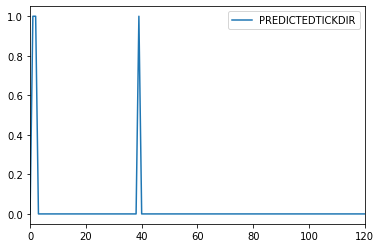

In [165]:
outcome3.plot()

In [3]:
classifier_model = 'gradient_boosting.sav'

In [7]:
def generate_class(classifier_model):
    
    # load classifier
    loaded_classifier = pickle.load(open(classifier_model, 'rb'))
    # read temp file
    df0 = pd.read_csv('tempfile_3.csv', index_col=0)
    # drop na
    df1 = df0.dropna()
    # initialize out df
    outDF = df1
    # define predicted features
    features = ['LS1'
            ,'LS2','LS3','LS4','LS5','LS6','LS7','LS8','LS9','LS10','LS11','LS12','LS13','LS14','LS15','LS16',
 'LS17','LS18','LS19','LS20','MS1','MS2','MS3','MS4','MS5','MS6','MS7','MS8','MS9','MS10','SS1','SS2','SS3','SS4',
 'SS5', 'BIDASKIMBALANCE']
    # iterate through the feautres and classify
    for f in features:
#        print(np.array(df1[f].values))
        # read the values
        X = np.array(df1[f].values)
        X1 = X.reshape(X.shape[0],1)
        y_score = loaded_classifier.predict_proba(X1)
        localPredict = []
        # determine probability threshold
        for i,j,k in zip(y_score[:,0], y_score[:,1], y_score[:,2]):

            if i > 0.23:
                predict = -1
                localPredict.append(predict)

            elif k > 0.25:
                predict = 1
                localPredict.append(predict)

            else:
                predict = 0
                localPredict.append(predict)

        col_name = f + '_c'
        localPrediction = pd.DataFrame({col_name: localPredict})
        outDF = outDF.join(localPrediction)
    # define classifier features
    features1 = ['LS1_c','LS2_c','LS3_c','LS4_c','LS5_c','LS6_c','LS7_c','LS8_c','LS9_c','LS10_c','LS11_c','LS12_c',
 'LS13_c','LS14_c','LS15_c','LS16_c','LS17_c','LS18_c','LS19_c','LS20_c','MS1_c','MS2_c','MS3_c','MS4_c',
 'MS5_c','MS6_c','MS7_c','MS8_c','MS9_c','MS10_c','SS1_c','SS2_c','SS3_c','SS4_c','SS5_c','BIDASKIMBALANCE_c']
    # select subset of classifier results
    result = outDF[features1]
    # aggregate across columns
    outDF['cum_pred'] = result.sum(axis = 1, skipna = True)
    # define how to select final class for flat
    outcome = pd.DataFrame(np.where((outDF['cum_pred']  >= -1) & (outDF['cum_pred'] <= 1) ,
                                     0, outDF['cum_pred'] ),
                           columns=['PREDICTEDTICKDIR'])
    # define how to select final class for down
    outcome2 = pd.DataFrame(np.where(outcome['PREDICTEDTICKDIR'] < -1, -1, outcome['PREDICTEDTICKDIR']),
                           columns=['PREDICTEDTICKDIR'])
    # define how to select final class for up
    outcome3 = pd.DataFrame(np.where(outcome2['PREDICTEDTICKDIR'] > 1, 1, outcome2['PREDICTEDTICKDIR']),
                           columns=['PREDICTEDTICKDIR'])
    # append the predicted tick in the output DF
    outDF['PREDICTEDTICKDIR'] = outcome3['PREDICTEDTICKDIR']
    # append the predicted tick in the output DF
    outDF['PREDICTEDTICKDIR'] = outDF['BIDASKIMBALANCE_c']
    # plot predicted tick
    outDF['PREDICTEDTICKDIR'].plot(legend=True, title='PREDICTED TICK DIR')
    # save the file in a temp file
    outDF.to_csv('output_file.csv')
    print("The output file is saved as output_file.csv")

The output file is saved as output_file.csv


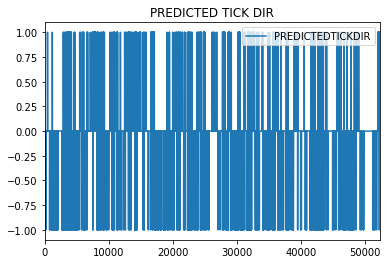

In [8]:
generate_class(classifier_model)

In [13]:
def evaluate_classifier_performance():
    # use temp file
    inputData = pd.read_csv('output_file.csv', index_col=0)
    # rename upcycle and down cycle columns
    y = inputData.TICKDIR.replace('UP', 1)
    y = y.replace('FLAT', 0)
    y = y.replace('DOWN', -1)
    # use all of the y as test
    y_test = y
    # use predicted tick direction
    localPredict = inputData.PREDICTEDTICKDIR
    # calculate accuracy score
    accuracy = accuracy_score(y_test, localPredict)
    print('The accuracy of the classifier is:', accuracy)
    # calculate the confusion matrix
    confmatrix = confusion_matrix(y_test, localPredict)
    print('The confusion matrix of the classifier is: \n', confmatrix)
    # print performance report
    print(classification_report(y_test, localPredict, labels=[-1,0,1]))

In [14]:
evaluate_classifier_performance()

ValueError: Classification metrics can't handle a mix of unknown and multiclass targets

In [29]:
# use temp file
inputData = pd.read_csv('output_file.csv', index_col=0)
# rename upcycle and down cycle columns
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('UPCYCLE', 'UP')
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('DOWNCYCLE', 'DOWN')
y = inputData.TICKDIR.replace('UP', 1)
y = y.replace('FLAT', 0)
y = y.replace('DOWN', -1)
# use all of the y as test
y_test = y
# use predicted tick direction
localPredict = inputData.PREDICTEDTICKDIR

In [30]:
accuracy = accuracy_score(y_test, localPredict)

In [31]:
y_test.shape

(52301,)

In [32]:
y[0]

0

In [33]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN     1820
FLAT    48328
UP       2153
Name: TIME, dtype: int64